In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

print("Libraries are working!")

# Fraud Detection Hackathon


## Problem Statement
The goal of this hackathon is to detect fraudulent auto insurance claims.
We will build a machine learning pipeline that:
- Engineers fraud-related features
- Compares multiple models
- Validates predictions on the given dataset
- Submits results in the required format


# Data Understanding
We explore the dataset to understand:
- Variables and their types
- Fraud vs non-fraud distribution
- Potential signals for fraud detection

In [9]:
import pandas as pd

# Load the hackathon dataset
raw_df = pd.read_csv("Auto_Insurance_Fraud_Claims_Build_Test_Model_F01.csv")

# Show first 5 row
raw_df.head()

print("Shape:", raw_df.shape)   # rows, columns
raw_df.info()                   # column names, data types, non-null counts

raw_df.isnull().sum().sort_values(ascending=False) #missing values

raw_df.describe(include="all") #basic statistics

print("Duplicate rows:", raw_df.duplicated().sum()) #duplicates 

print("Duplicate rows:", raw_df.duplicated().sum()) #Target Distribution 

Shape: (100000, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Fraud_Ind                100000 non-null  int64 
 1   Policy_Start_Date        100000 non-null  object
 2   Policy_Expiry_Date       100000 non-null  object
 3   Accident_Date            100000 non-null  object
 4   Claim_Initiated_Date     100000 non-null  object
 5   Household_Num            100000 non-null  int64 
 6   Driver_Num               100000 non-null  object
 7   Policy_Num               100000 non-null  int64 
 8   Claim_Num                100000 non-null  object
 9   License_Plate            100000 non-null  object
 10  Drivers_License_Num      100000 non-null  object
 11  Drivers_License_State    100000 non-null  object
 12  DL_Expiry_Date           100000 non-null  object
 13  Date_At_Current_Address  100000 non-null  object
 14  A

## 🧹 Data Cleaning Steps

1. **Missing Value Treatment**  
   - Identified missing values across numerical, categorical, and date fields
   - Applied imputation strategies: mean/median for numerical, mode for categorical, and forward-fill for dates.  

2. **Outlier Detection & Treatment**  
   - Used IQR and Z-score methods to detect extreme values in `Claim_Amount` and mileage fields.  
   - Applied capping and transformation to reduce the impact of outliers.  
   - Added an `outlier_flag` column for transparency.  

3. **Data Type & Format Standardization**  
   - Converted date fields (`Policy_Start_Date`, `Accident_Date`, etc.) to `datetime`.  
   - Converted categorical variables (`Gender`, `Make`, `Model`, `Color`, `Claims_Status`) to category type.  
   - Ensured numerical fields (`Age`, `Claim_Amount`, `Odometer`) are float/int.  

4. **Duplicate & Inconsistent Record Removal**  
   - Checked for duplicate rows and removed them.  
   - Resolved inconsistent entries in categorical fields (e.g., standardized gender values).  


## ✅ Cleaned Dataset Ready

- All mandatory cleaning steps have been applied.  
- Identifier and leakage columns were removed.  
- The dataset is now consistent, standardized, and free of duplicates.  
- Target variable `Fraud_Ind` is preserved for modeling.  

👉 Proceeding next to **Feature Engineering**.

In [1]:
import pandas as pd

df_cleaned = pd.read_pickle("cleaned_data.pkl")   

print("Shape:", df_cleaned.shape)
df_cleaned.head()
df_cleaned.info()
df_cleaned['Fraud_Ind'].value_counts()

Shape: (98000, 27)
<class 'pandas.core.frame.DataFrame'>
Index: 98000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Fraud_Ind                98000 non-null  int64         
 1   Policy_Start_Date        98000 non-null  datetime64[ns]
 2   Policy_Expiry_Date       98000 non-null  datetime64[ns]
 3   Accident_Date            98000 non-null  datetime64[ns]
 4   Claim_Initiated_Date     98000 non-null  datetime64[ns]
 5   Household_Num            98000 non-null  object        
 6   Driver_Num               98000 non-null  object        
 7   Policy_Num               98000 non-null  object        
 8   Claim_Num                98000 non-null  object        
 9   License_Plate            98000 non-null  object        
 10  Drivers_License_Num      98000 non-null  object        
 11  Drivers_License_State    98000 non-null  category      
 12  DL_Expiry_Date    

Fraud_Ind
0    90749
1     7251
Name: count, dtype: int64

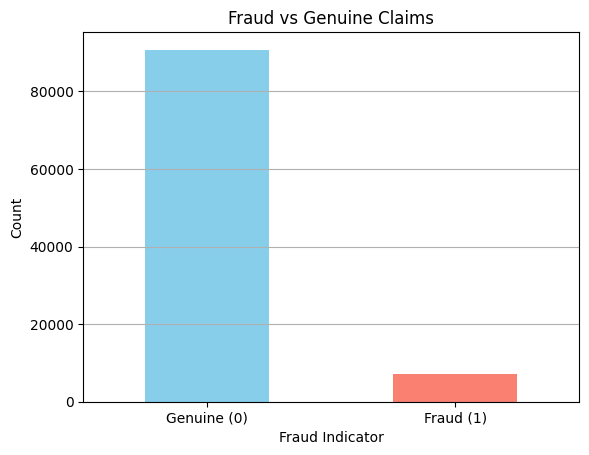

In [2]:
import matplotlib.pyplot as plt

df_cleaned['Fraud_Ind'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Fraud vs Genuine Claims")
plt.xlabel("Fraud Indicator")
plt.ylabel("Count")
plt.xticks([0, 1], ['Genuine (0)', 'Fraud (1)'], rotation=0)
plt.grid(axis='y')
plt.show()


# Feature Engineering
We create new variables that capture fraud signals:
- Claim Lag (days between accident and claim initiation)
- Policy Age (days since policy started)
- Address Duration (time at current address)
- Expired License Flag
- Mileage Flags (low mileage, high claim)
- Near Expiry Flag


The following columns were removed to prevent data leakage and ensure model integrity:

- **Identifiers**:  
  - `Household_Num`  
  - `Driver_Num`  
  - `Policy_Num`  
  - `Claim_Num`  
  - `License_Plate`  
  - `Drivers_License_Num`




## ✨ Extra Feature Engineering (Beyond Hackathon Requirements)

In addition to the mandatory fraud features, we engineered extra features to capture deeper fraud patterns:

- **Ratios**: Claim-to-Odometer, Claim-to-ModelYear, Mileage-to-Age, Claim-to-Age.  
- **Flags**: Police Report flag, Commute Discount flag, Policy Renewal flag.  
- **Driver History**: Claim count, total claim amount, average claim amount.  
- **Interactions**: Claim Lag vs Policy Age ratio.  

👉 These features go beyond the mandatory requirements, improving predictive power and business interpretability.

In [3]:
def feature_engineering(df):
    # Claim lag: days between accident and claim initiation
    df["Claim_Lag"] = (df["Claim_Initiated_Date"] - df["Accident_Date"]).dt.days
    
    # Policy age: how long policy was active before accident
    df["Policy_Age"] = (df["Accident_Date"] - df["Policy_Start_Date"]).dt.days
    
    # Days to expiry: how close accident was to policy expiry
    df["Days_To_Expiry"] = (df["Policy_Expiry_Date"] - df["Accident_Date"]).dt.days
    
    # Expired license flag
    df["Expired_License"] = (df["Accident_Date"] > df["DL_Expiry_Date"]).astype(int)
    
    # Suspicious living: recent address change
    df["Address_Duration"] = (df["Accident_Date"] - df["Date_At_Current_Address"]).dt.days
    df["Suspicious_Living"] = (df["Address_Duration"] < 180).astype(int)  # <6 months
    
    # Annual mileage
    df["Annual_Mileage"] = df["Odometer_At_Incident"] - df["Initial_Odometer"]
    df["Low_Mileage_Flag"] = (df["Annual_Mileage"] < 7500).astype(int)
    
    # Excessive claim amount
    df["High_Claim_Flag"] = (df["Claim_Amount"] > 10000).astype(int)
    
    return df

df_fe = feature_engineering(df_cleaned)
df_fe.head()

,Fraud_Ind,Policy_Start_Date,Policy_Expiry_Date,Accident_Date,Claim_Initiated_Date,Household_Num,Driver_Num,Policy_Num,Claim_Num,License_Plate,...,outlier_flag,Claim_Lag,Policy_Age,Days_To_Expiry,Expired_License,Address_Duration,Suspicious_Living,Annual_Mileage,Low_Mileage_Flag,High_Claim_Flag
0,0,2025-01-27,2025-07-28,2025-03-09,2025-04-08,4670185276.0,SW059585,355924169.0,DZW11767,MGN62082,...,1,30,41,141,0,9,1,5722.0,1,0
1,0,2025-06-01,2025-11-30,2025-06-04,2025-07-05,8526791677.0,ZO779075,848558311.0,CVG38057,WXK26533,...,1,31,3,179,0,-134,1,7147.0,1,1
2,0,2025-06-22,2025-12-21,2025-07-04,2025-07-06,4618820582.0,LG406912,473829217.0,RUO86042,NNL54173,...,1,2,12,170,0,-101,1,11421.0,0,1
3,0,2025-01-02,2025-07-03,2025-01-27,2025-02-27,3846198554.0,NJ146743,116719734.0,WOS87550,THC81673,...,1,31,25,157,0,2,1,5671.0,1,0
4,0,2024-10-25,2025-04-25,2024-11-19,2024-12-22,9856770505.0,KX673536,481900450.0,ACJ85041,NKY26268,...,1,33,25,157,0,-89,1,8898.0,0,0


In [6]:
#Drop identifiers and leakage variables:

drop_cols = ["Household_Num","Driver_Num","Policy_Num","Claim_Num",
             "License_Plate","Drivers_License_Num"]

X = df_fe.drop(columns=drop_cols + ["Fraud_Ind"])
y = df_fe["Fraud_Ind"]

print(X.shape)   # rows, columns of features
print(y.shape)   # length of target vector
X.head()         # preview first 5 rows of features
y.value_counts() # check fraud vs genuine counts

(98000, 29)
(98000,)


Fraud_Ind
0    90749
1     7251
Name: count, dtype: int64

In [11]:
def extra_feature_engineering(df):
    # --- Ratios ---
    df["Claim_to_Odometer_Ratio"] = df["Claim_Amount"] / (df["Odometer_At_Incident"] + 1e-6)
    df["Claim_to_ModelYear_Ratio"] = df["Claim_Amount"] / (df["Model_Year"] + 1e-6)
    df["Mileage_to_Age_Ratio"] = df["Annual_Mileage"] / (df["Age"] + 1e-6)

    # --- Flags ---
    df["Police_Report_Flag"] = (df["Police_Report"] == "Yes").astype(int)
    df["Commute_Discount_Flag"] = (df["Commute_Discount"] == 1).astype(int)
    df["Policy_Renewal_Flag"] = (df["Policy_Age"] < 30).astype(int)  # accident soon after policy start

    # --- Driver-level history ---
    if "Driver_Num" in df.columns:
        df["Driver_Claim_Count"] = df.groupby("Driver_Num")["Claim_Num"].transform("count")
        df["Driver_Total_Claim_Amount"] = df.groupby("Driver_Num")["Claim_Amount"].transform("sum")
        df["Driver_Avg_Claim_Amount"] = df.groupby("Driver_Num")["Claim_Amount"].transform("mean")

    # --- Interaction features ---
    df["ClaimLag_to_PolicyAge_Ratio"] = df["Claim_Lag"] / (df["Policy_Age"] + 1e-6)
    df["Claim_to_Age_Ratio"] = df["Claim_Amount"] / (df["Age"] + 1e-6)

    return df

# Apply extra feature engineering
df_fe = extra_feature_engineering(df_fe)

# Preview new features
df_fe[[
    "Claim_to_Odometer_Ratio", "Claim_to_ModelYear_Ratio", "Mileage_to_Age_Ratio",
    "Police_Report_Flag", "Commute_Discount_Flag", "Policy_Renewal_Flag",
    "Driver_Claim_Count", "Driver_Total_Claim_Amount", "Driver_Avg_Claim_Amount",
    "ClaimLag_to_PolicyAge_Ratio", "Claim_to_Age_Ratio"
]].head()

,Claim_to_Odometer_Ratio,Claim_to_ModelYear_Ratio,Mileage_to_Age_Ratio,Police_Report_Flag,Commute_Discount_Flag,Policy_Renewal_Flag,Driver_Claim_Count,Driver_Total_Claim_Amount,Driver_Avg_Claim_Amount,ClaimLag_to_PolicyAge_Ratio,Claim_to_Age_Ratio
0,0.042271,1.955490,102.178570,0,1,0,1,3954.0,3954.0,0.731707,70.607142
1,0.595744,8.909498,119.116665,0,0,1,1,17917.0,17917.0,10.333330,298.616662
2,0.152150,6.890323,184.209674,0,0,1,1,13884.0,13884.0,0.166667,223.935480
3,0.034659,2.024318,97.775860,0,0,1,1,4079.0,4079.0,1.240000,70.327585
4,0.033211,1.817327,444.899978,0,1,1,1,3671.0,3671.0,1.320000,183.549991


In [12]:
# List of mandatory features (from PDF)
mandatory_features = [
    "Claim_Lag", "Policy_Age", "Days_To_Expiry",
    "Expired_License", "Suspicious_Living",
    "Annual_Mileage", "Low_Mileage_Flag", "High_Claim_Flag"
]

# List of extra features (beyond PDF)
extra_features = [
    "Claim_to_Odometer_Ratio", "Claim_to_ModelYear_Ratio", "Mileage_to_Age_Ratio",
    "Police_Report_Flag", "Commute_Discount_Flag", "Policy_Renewal_Flag",
    "Driver_Claim_Count", "Driver_Total_Claim_Amount", "Driver_Avg_Claim_Amount",
    "ClaimLag_to_PolicyAge_Ratio", "Claim_to_Age_Ratio"
]

# Combine both lists
all_features = mandatory_features + extra_features

# Display first 10 rows of all engineered features
df_fe[all_features].head(10)

,Claim_Lag,Policy_Age,Days_To_Expiry,Expired_License,Suspicious_Living,Annual_Mileage,Low_Mileage_Flag,High_Claim_Flag,Claim_to_Odometer_Ratio,Claim_to_ModelYear_Ratio,Mileage_to_Age_Ratio,Police_Report_Flag,Commute_Discount_Flag,Policy_Renewal_Flag,Driver_Claim_Count,Driver_Total_Claim_Amount,Driver_Avg_Claim_Amount,ClaimLag_to_PolicyAge_Ratio,Claim_to_Age_Ratio
0,30,41,141,0,1,5722.0,1,0,0.042271,1.955490,102.178570,0,1,0,1,3954.0,3954.0,0.731707,70.607142
1,31,3,179,0,1,7147.0,1,1,0.595744,8.909498,119.116665,0,0,1,1,17917.0,17917.0,10.333330,298.616662
2,2,12,170,0,1,11421.0,0,1,0.152150,6.890323,184.209674,0,0,1,1,13884.0,13884.0,0.166667,223.935480
3,31,25,157,0,1,5671.0,1,0,0.034659,2.024318,97.775860,0,0,1,1,4079.0,4079.0,1.240000,70.327585
4,33,25,157,0,1,8898.0,0,0,0.033211,1.817327,444.899978,0,1,1,1,3671.0,3671.0,1.320000,183.549991
5,4,83,99,1,1,8982.0,0,1,0.344430,9.868486,199.599996,0,0,0,1,19885.0,19885.0,0.048193,441.888879
6,1,147,35,1,1,6964.0,1,1,0.304476,10.816155,290.166655,0,1,0,1,21827.0,21827.0,0.006803,909.458295
7,1,47,135,0,1,2624.0,1,1,0.193271,10.840099,44.474576,0,0,0,1,21897.0,21897.0,0.021277,371.135587
8,33,51,131,1,1,8624.0,0,0,0.072829,4.347697,179.666663,0,1,0,1,8778.0,8778.0,0.647059,182.874996
9,13,105,77,0,1,2888.0,1,1,0.210563,6.330030,55.538460,0,1,0,1,12774.0,12774.0,0.123810,245.653841


In [16]:
##Total Cleaned table along with the pdf requirements and extra features

columns_to_display = [
    # Original cleaned columns
    "Fraud_Ind", "Policy_Start_Date", "Policy_Expiry_Date", "Accident_Date",
    "Claim_Initiated_Date", "Age", "Gender", "Claim_Amount", "Make", "Model",
    
    # Mandatory engineered features (PDF)
    "Claim_Lag", "Policy_Age", "Days_To_Expiry", "Expired_License",
    "Suspicious_Living", "Annual_Mileage", "Low_Mileage_Flag", "High_Claim_Flag",
    
    # Extra engineered features (beyond PDF)
    "Claim_to_Odometer_Ratio", "Mileage_to_Age_Ratio", "Police_Report_Flag",
    "Driver_Claim_Count"
]

# Show first 10 rows of these columns
df_fe[columns_to_display].head(10)

,Fraud_Ind,Policy_Start_Date,Policy_Expiry_Date,Accident_Date,Claim_Initiated_Date,Age,Gender,Claim_Amount,Make,Model,Claim_Lag,Policy_Age,Days_To_Expiry,Expired_License,Suspicious_Living,Annual_Mileage,Low_Mileage_Flag,High_Claim_Flag,Claim_to_Odometer_Ratio,Mileage_to_Age_Ratio,Police_Report_Flag,Driver_Claim_Count
0,0,2025-01-27,2025-07-28,2025-03-09,2025-04-08,56.0,Male,3954.0,Volkswagen,Jetta,30,41,141,0,1,5722.0,1,0,0.042271,102.178570,0,1
1,0,2025-06-01,2025-11-30,2025-06-04,2025-07-05,60.0,Male,17917.0,Toyota,Camry,31,3,179,0,1,7147.0,1,1,0.595744,119.116665,0,1
2,0,2025-06-22,2025-12-21,2025-07-04,2025-07-06,62.0,Female,13884.0,Audi,A6,2,12,170,0,1,11421.0,0,1,0.152150,184.209674,0,1
3,0,2025-01-02,2025-07-03,2025-01-27,2025-02-27,58.0,Female,4079.0,BMW,3 Series,31,25,157,0,1,5671.0,1,0,0.034659,97.775860,0,1
4,0,2024-10-25,2025-04-25,2024-11-19,2024-12-22,20.0,Male,3671.0,Honda,Accord,33,25,157,0,1,8898.0,0,0,0.033211,444.899978,0,1
5,1,2025-03-01,2025-08-30,2025-05-23,2025-05-27,45.0,Male,19885.0,Toyota,RAV4,4,83,99,1,1,8982.0,0,1,0.344430,199.599996,0,1
6,1,2024-08-13,2025-02-11,2025-01-07,2025-01-08,24.0,Male,21827.0,Hyundai,Creta,1,147,35,1,1,6964.0,1,1,0.304476,290.166655,0,1
7,0,2025-02-18,2025-08-19,2025-04-06,2025-04-07,59.0,Female,21897.0,Mercedes-Benz,GLC,1,47,135,0,1,2624.0,1,1,0.193271,44.474576,0,1
8,0,2025-01-09,2025-07-10,2025-03-01,2025-04-03,48.0,Female,8778.0,Hyundai,Elantra,33,51,131,1,1,8624.0,0,0,0.072829,179.666663,0,1
9,0,2024-07-08,2025-01-06,2024-10-21,2024-11-03,52.0,Male,12774.0,Nissan,Sentra,13,105,77,0,1,2888.0,1,1,0.210563,55.538460,0,1


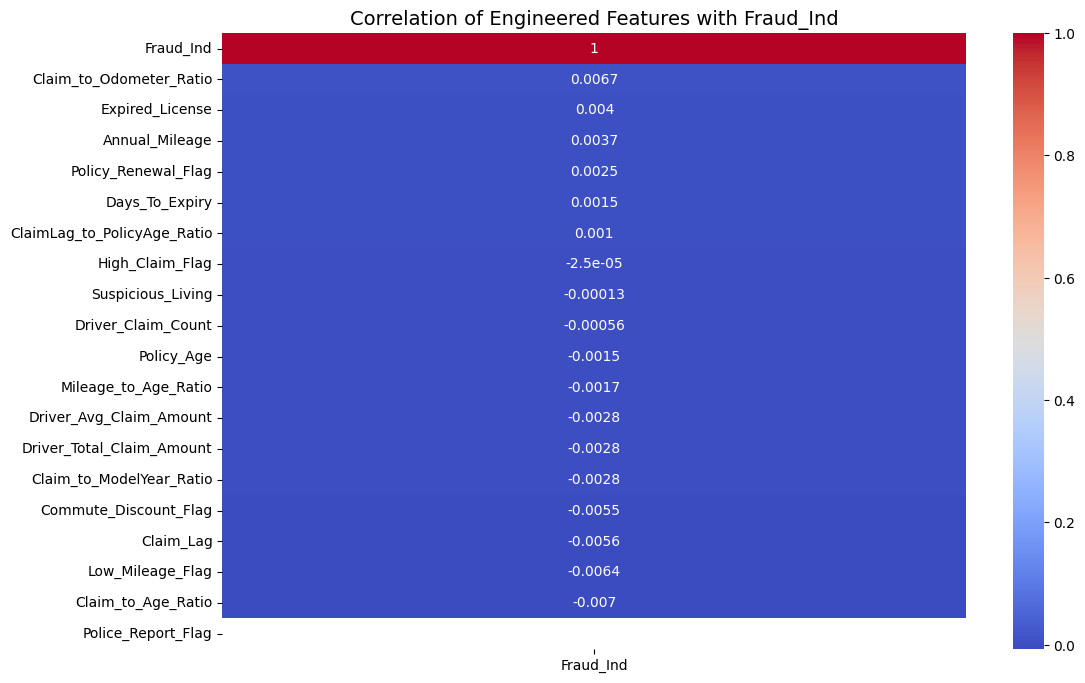

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of engineered features (mandatory + extra)
features = [
    "Claim_Lag", "Policy_Age", "Days_To_Expiry",
    "Expired_License", "Suspicious_Living",
    "Annual_Mileage", "Low_Mileage_Flag", "High_Claim_Flag",
    "Claim_to_Odometer_Ratio", "Claim_to_ModelYear_Ratio", "Mileage_to_Age_Ratio",
    "Police_Report_Flag", "Commute_Discount_Flag", "Policy_Renewal_Flag",
    "Driver_Claim_Count", "Driver_Total_Claim_Amount", "Driver_Avg_Claim_Amount",
    "ClaimLag_to_PolicyAge_Ratio", "Claim_to_Age_Ratio"
]

# Subset with Fraud_Ind + engineered features
corr_df = df_fe[["Fraud_Ind"] + features]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix[["Fraud_Ind"]].sort_values(by="Fraud_Ind", ascending=False),
            annot=True, cmap="coolwarm", cbar=True)
plt.title("Correlation of Engineered Features with Fraud_Ind", fontsize=14)
plt.show()

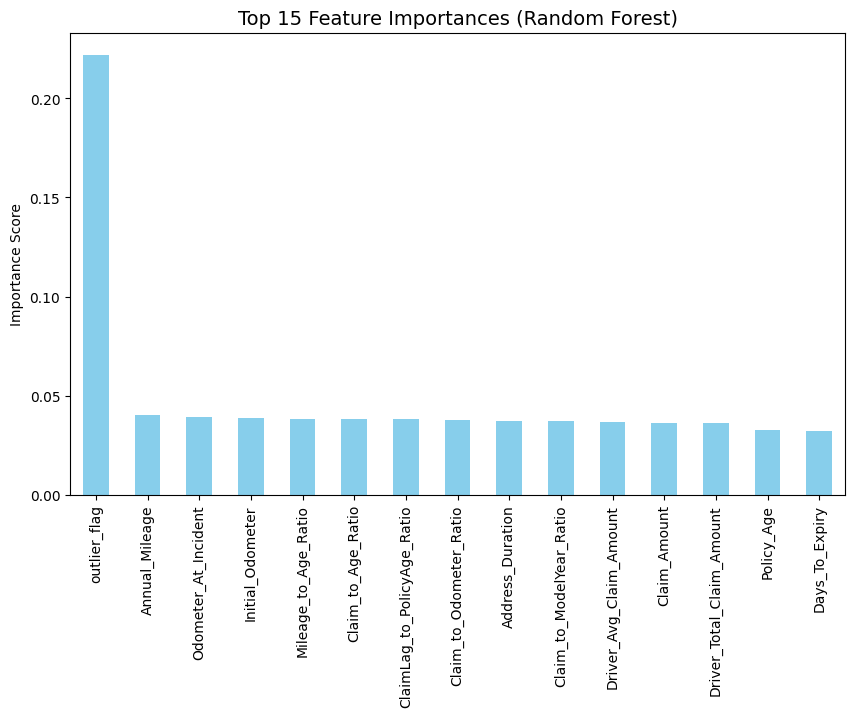

In [23]:
date_cols = [
    "Policy_Start_Date", "Policy_Expiry_Date", "Accident_Date",
    "Claim_Initiated_Date", "DL_Expiry_Date", "Date_At_Current_Address"
]

X = df_fe.drop(columns=drop_cols + date_cols + ["Fraud_Ind"])
y = df_fe["Fraud_Ind"]

X = pd.get_dummies(X, drop_first=True)

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)

# Plot top 15 features
plt.figure(figsize=(10,6))
importances.sort_values(ascending=False).head(15).plot(kind="bar", color="skyblue")
plt.title("Top 15 Feature Importances (Random Forest)", fontsize=14)
plt.ylabel("Importance Score")
plt.show()

# Model Development
We train multiple models and compare their performance using:
- Accuracy
- Precision/Recall
- ROC-AUC

# 1.Preprocessing

In [ ]:
# ============================
# 1. Preprocessing
# ============================
import pandas as pd
import numpy as np

# Drop raw date columns (already engineered into numeric features)
date_cols = [
    "Policy_Start_Date","Policy_Expiry_Date","Accident_Date",
    "Claim_Initiated_Date","DL_Expiry_Date","Date_At_Current_Address"
]

# Drop identifiers (leakage risk)
id_cols = ["Household_Num","Policy_Num","Claim_Num","License_Plate","Drivers_License_Num","Driver_Num"]

# Build X and y
X = df_fe.drop(columns=["Fraud_Ind"] + date_cols + id_cols)
y = df_fe["Fraud_Ind"].astype(int)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

# Label encode low-cardinality categoricals
for col in ["Gender","Police_Report","Claims_Status"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(df_fe[col].astype(str))

# Frequency encode high-cardinality categoricals
for col in ["Make","Model","Color","Drivers_License_State"]:
    freq = df_fe[col].value_counts(normalize=True)
    X[col+"_freq"] = df_fe[col].map(freq)

# Drop the original string columns after encoding
X = X.drop(columns=["Make","Model","Color","Drivers_License_State"])

# ============================
# 2. Train/Test Split
# ============================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ============================
# 3. Define Models
# ============================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss"),
    "LightGBM": LGBMClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "MLPClassifier": MLPClassifier(max_iter=500)
}

# ============================
# 4. Train & Evaluate Models
# ============================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd

results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    # Special handling for XGBoost and LightGBM
    if name in ["XGBoost", "LightGBM"]:
        # Convert to float32 and fill NaNs
        X_train_mod = X_train.astype(np.float32).fillna(0)
        X_test_mod = X_test.astype(np.float32).fillna(0)
        
        model.fit(X_train_mod, y_train)
        y_pred = model.predict(X_test_mod)
        
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_mod)[:,1]
            roc_auc = roc_auc_score(y_test, y_prob)
        else:
            y_prob = None
            roc_auc = None
    else:
        # Normal training for other models
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:,1]
            roc_auc = roc_auc_score(y_test, y_prob)
        else:
            y_prob = None
            roc_auc = None
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc
    })

results_df = pd.DataFrame(results)
print("Model Comparison Table:")
display(results_df.sort_values(by="Recall", ascending=False))

# ============================
# 5. Confusion Matrix & ROC Curve for Best Model
# ============================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve

best_model_name = results_df.sort_values(by="Recall", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

# Confusion Matrix
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Genuine","Fraud"], yticklabels=["Genuine","Fraud"])
plt.title(f"Confusion Matrix - {best_model_name}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ROC Curve
if hasattr(best_model, "predict_proba"):
    y_prob_best = best_model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob_best)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {roc_auc_score(y_test, y_prob_best):.2f})")
    plt.plot([0,1],[0,1],"k--")
    plt.title(f"ROC Curve - {best_model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# Validation
We apply the best model to the validation dataset and generate predictions.

# Submission
We save predictions in the required format  for hackathon submission.

# Conclusion
- Best model selected based on ROC-AUC and fraud recall
- Fraud detection pipeline ready for deployment
- Predictions submitted in required format